# Deskripsi
Deskripsi mengenai variable-variabel yang ada dalam penelitian ini akan dijelaskan dalam beberapa bagian:

1. Loading and General Description
2. Crawling indicator Description
3. 'News' Variables Description

## 0. Load Library

In [1]:
import matplotlib.pyplot as plt
import os, re

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer
from datetime import datetime as dt
import cPickle as pickle
import re #Regex
import seaborn as sns
sns.set()
%matplotlib inline

## 1. Load and General Description

In [2]:
import MySQLdb
import pandas as pd

mysql_cn = MySQLdb.connect(host = "localhost",
                     user = "root",
                     passwd = "",
                     db = "news_yii")
df_mysql = pd.read_sql('select * from news;', con=mysql_cn,index_col='id')
dfNewsLink_mysql = pd.read_sql('select * from newslink;', con=mysql_cn, index_col='id')
mysql_cn.close()

print df_mysql.shape
df_mysql[df_mysql.index == 58445].transpose()

(58446, 11)


id,58445
created_at,2016-06-10 14:51:34
updated_at,None
sumber,8
url,http://jakarta.bisnis.com/read/20160610/77/556...
judul,Ini Pengalihan Arus Selama Pengerjaan Simpang ...
shortDesc,Dinas Perhubungan dan Transportasi Provinsi DK...
longDesc,"\tBisnis.com, JAKARTA - Dinas ..."
published,2016-06-10 14:40:39
crawlTime,0.4834
crawlMem,2088


In [3]:
df_mysql[df_mysql.index == 58445]

,created_at,updated_at,sumber,url,judul,shortDesc,longDesc,published,crawlTime,crawlMem,flag
id,,,,,,,,,,,
58445,2016-06-10 14:51:34,None,8,http://jakarta.bisnis.com/read/20160610/77/556...,Ini Pengalihan Arus Selama Pengerjaan Simpang ...,Dinas Perhubungan dan Transportasi Provinsi DK...,"\tBisnis.com, JAKARTA - Dinas ...",2016-06-10 14:40:39,0.4834,2088,-1


In [3]:
print dfNewsLink_mysql.shape
dfNewsLink_mysql[dfNewsLink_mysql.index == 3]

(8, 3)


,descr,url,crawlClass
id,,,
3,Liputan6 - All,http://www.liputan6.com/feed/rss2,div=itemprop=description


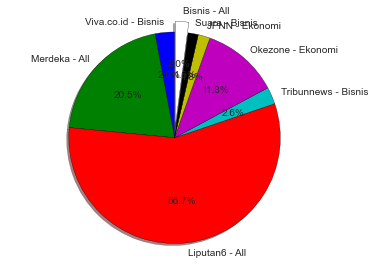

In [4]:
dataPie = df_mysql.groupby(['sumber'])['url'].count()
describ = dfNewsLink_mysql['descr'].tolist()

labels = describ
sizes = dataPie
explode = [0]*len(labels)  # only "explode" the 2nd slice (i.e. 'Hogs')

#Sorot Liputan6 yang id=3, tapi karena dari 0, jadi 2
explode[7]=.1

plt.pie(sizes, explode=explode, labels=labels,
         autopct='%1.1f%%', shadow=True, startangle=90)
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')

fig = plt.figure()

In [5]:
from collections import Counter
newsByDate = df_mysql[~df_mysql.published.isnull()]
counted_dates = Counter(newsByDate.published.apply(lambda x: x.strftime("%Y-%m-%d")))
counted_series = pd.Series(counted_dates)
print 'Awal Crawl  : ',counted_series.head(1).index.values
print 'Akhir Crawl : ',counted_series.tail(1).index.values

Awal Crawl  :  ['2016-04-18']
Akhir Crawl :  ['2016-06-10']


In [6]:
import datetime as dt
def countByHour(x):
    newsByDate = x[~x.published.isnull()]
    counted_dates = Counter(newsByDate.published.apply(lambda x: x.strftime("%H")))
    counted_series = pd.Series(counted_dates)
    return counted_series

def countByDay(x):
    newsByDate = x[~x.published.isnull()]
    counted_dates = Counter(newsByDate.published.apply(lambda x: x.strftime("%Y-%m-%d")))
    counted_series = pd.Series(counted_dates)
    counted_series.index = pd.to_datetime(counted_series.index)
    return counted_series

def countByWeek(x):
    newsByDate = x[~x.published.isnull()]
    counted_dates = Counter(newsByDate.published.apply(lambda x: x.weekday()))
    counted_series = pd.Series(counted_dates)
    return counted_series

byHour = countByHour(df_mysql)
byDate = countByDay(df_mysql)
byWeek = countByWeek(df_mysql)

In [7]:
top3hour = byHour.sort_values(ascending=False).head(3)
top3day  = byWeek.sort_values(ascending=False).head(3)
print 'Jam paling produktif  : \n',top3hour.index.values,'\n',top3hour.values
print 'Hari paling produktif : \n',top3day.index.values,'\n',top3day.values

Jam paling produktif  : 
['12' '11' '07'] 
[3930 3811 3811]
Hari paling produktif : 
[2 1 0] 
[10855 10751  9396]


C:\Users\Thosan Girisona S\Anaconda\lib\site-packages\matplotlib\figure.py:387: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


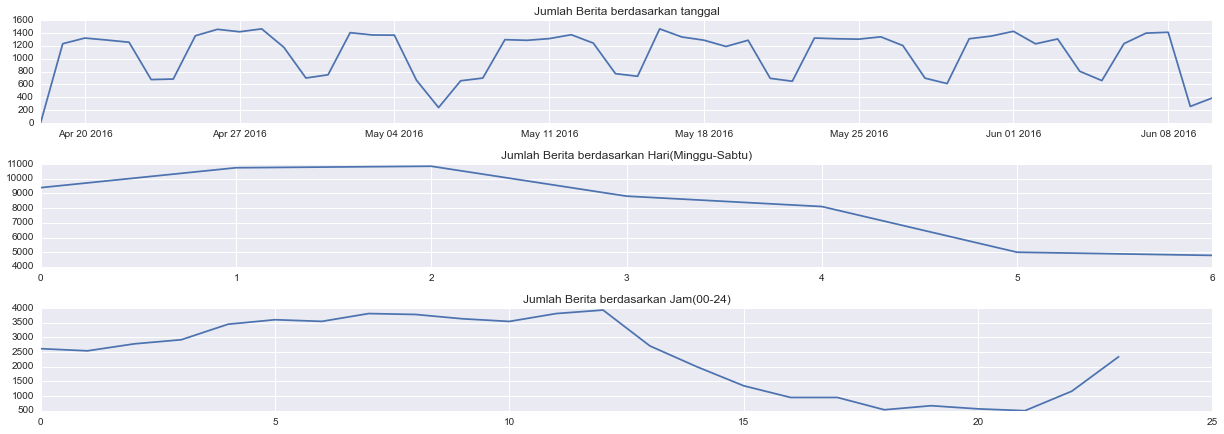

In [7]:
import matplotlib.pyplot as plt
from matplotlib.dates import date2num
import datetime

fig, axes = plt.subplots(nrows=3,figsize=(21,7))
axes[0].plot_date(date2num(byDate.index.to_pydatetime()),byDate.values,'-')
axes[0].set_title('Jumlah Berita berdasarkan tanggal')
axes[1].plot(byWeek.index,byWeek.values)
axes[1].set_title('Jumlah Berita berdasarkan Hari(Minggu-Sabtu)')
axes[2].plot(byHour.index,byHour.values)
axes[2].set_title('Jumlah Berita berdasarkan Jam(00-24)')

fig.subplots_adjust(hspace = 0.4)
fig.show()

### Insight

1. Total Daily
       Dari plot pertama, bisa dilihat bahwa jumlah berita yang muncul per harinya cenderung berpola naik dan turun secara teratur. Pola tersebut ada berdasarkan perbedaan hari.
   
2. Total Weekly
       Unik karena ternyata jumlah berita yang muncul menurun pada hari kerja, dan mulai naik lagi dari hari minggu, mungkin karena hari jumat dan sabtu banyak kantor-kantor yang sudah tidak aktif secara penuh lagi, sehingga sumber-sumber berita berkurang
   
3. Total Hourly
       jumlah berita mencapai puncaknya jam 12 siang, namun sudah tinggi sejak pagi. Mungkin terkait jam kerja reporter, jumlah berita langsung menurun sedari jam 12 dan jumlah berita yang paling sedikit ada di jam 19-21. Mungkin karena reporter yang mendapatkan berita pada malam hari dipublikasinya pagi esoknya, jumlah berita mulai naik pukul 22 hingga esok paginya. 

## 1. Crawling Indicator

In [8]:
DATA_ANALSISIS_crawl = df_mysql[df_mysql.crawlMem.notnull()] #Yang sudah di crawl
crawlIndicator = pd.DataFrame([DATA_ANALSISIS_crawl.crawlMem,DATA_ANALSISIS_crawl.crawlTime]).transpose()
pickle.dump(DATA_ANALSISIS_crawl, open( "v1.4\DATA_ANALSISIS_crawl-v2.p", "wb" ) )
crawlIndicator.describe()

,crawlMem,crawlTime
count,13965.000000,13965.000000
mean,3252.317651,0.434459
std,701.726627,0.734470
min,2080.000000,0.000000
25%,2808.000000,0.132800
50%,2808.000000,0.156600
75%,4072.000000,0.511900
max,6832.000000,21.701800


## BOXPLOT Crawl

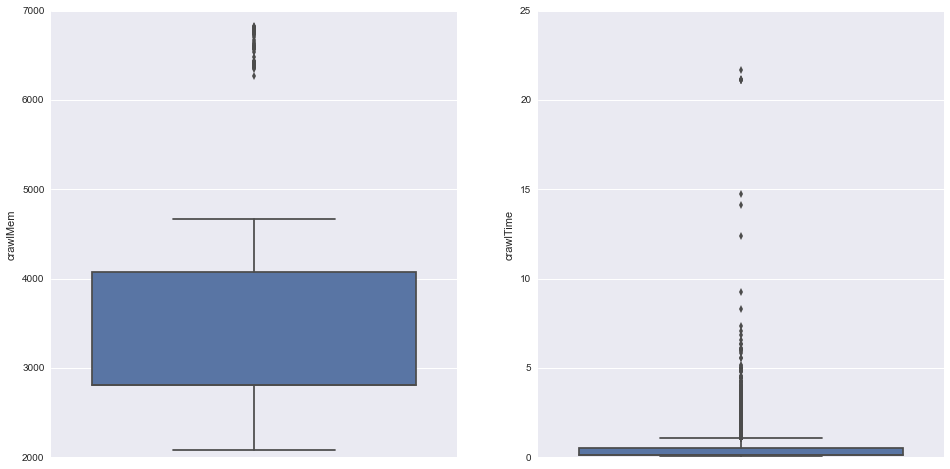

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(ncols=2,figsize=(16,8))

sns.boxplot(DATA_ANALSISIS_crawl.crawlMem, orient = 'v',ax=ax[0])
sns.boxplot(DATA_ANALSISIS_crawl.crawlTime, orient = 'v', ax=ax[1])

plt.show()

In [10]:
crawlTime_weird = DATA_ANALSISIS_crawl[DATA_ANALSISIS_crawl.crawlTime > DATA_ANALSISIS_crawl.crawlTime.quantile(0.75)]
print 'Paling Lama'
crawlTime_weird.sort_values(by='crawlTime', ascending=False).head(1).transpose()

Paling Lama


id,37737
created_at,2016-05-23 01:00:49
updated_at,None
sumber,5
url,http://economy.okezone.com/read/2016/05/21/470...
judul,"Intip Rumah dengan Tarif Sewa Rp13,6 Miliar/Bu..."
shortDesc,Rumah bernama Sandcastle Estate itu memiliki l...
longDesc,\t\t\t\t\t\t\tNEW YORK - Sebuah rumah mewah di...
published,2016-05-22 17:14:39
crawlTime,21.7018
crawlMem,4088


In [11]:
crawlTime_weird = DATA_ANALSISIS_crawl[DATA_ANALSISIS_crawl.crawlMem > DATA_ANALSISIS_crawl.crawlMem.quantile(0.75)]
print 'Paling Berat'
crawlTime_weird.sort_values(by='crawlMem', ascending=False).head(1).transpose()

Paling Berat


id,11469
created_at,2016-04-28 08:06:03
updated_at,None
sumber,5
url,http://economy.okezone.com/read/2016/04/27/278...
judul,"TERPOPULER: Bukukan Rugi 22%, Saham Astra dan ..."
shortDesc,Penurunan laba bersih PT Astra International T...
longDesc,\t\t\t\t\t\t\tJAKARTA - Penurunan laba bersih ...
published,2016-04-28 00:47:15
crawlTime,0.1954
crawlMem,6832


In [12]:
DATA_ANALSISIS_crawl    = DATA_ANALSISIS_crawl[DATA_ANALSISIS_crawl.flag.isin([-1, 1])]
DATA_ANALSISIS_crawlPos = DATA_ANALSISIS_crawl[DATA_ANALSISIS_crawl.flag == 1]
DATA_ANALSISIS_crawlNeg = DATA_ANALSISIS_crawl[DATA_ANALSISIS_crawl.flag == -1]
crawlAnalysis = pd.DataFrame([DATA_ANALSISIS_crawlPos.crawlMem,DATA_ANALSISIS_crawlPos.crawlTime,
                              DATA_ANALSISIS_crawlNeg.crawlMem,DATA_ANALSISIS_crawlNeg.crawlTime]).transpose()
crawlAnalysis.columns = ['Memory Pos','Time Pos','Memory Neg','Time Neg']
print 'Memory Pos : ',sum(DATA_ANALSISIS_crawlPos.crawlMem), 'Byte'
print 'Memory Neg : ',sum(DATA_ANALSISIS_crawlNeg.crawlMem), 'Byte'
print 'Time Pos : ',sum(DATA_ANALSISIS_crawlPos.crawlTime), 'Detik'
print 'Time Neg : ',sum(DATA_ANALSISIS_crawlNeg.crawlTime),'Detik'
crawlAnalysis.describe()

Memory Pos :  377552.0 Byte
Memory Neg :  45041064.0 Byte
Time Pos :  34.7887 Detik
Time Neg :  6032.4353 Detik


,Memory Pos,Time Pos,Memory Neg,Time Neg
count,110.000000,110.000000,13855.000000,13855.000000
mean,3432.290909,0.316261,3250.888777,0.435398
std,863.851110,0.565705,700.142556,0.735595
min,2368.000000,0.046600,2080.000000,0.000000
25%,2520.000000,0.129025,2808.000000,0.132800
50%,3920.000000,0.145450,2808.000000,0.156700
75%,4072.000000,0.200300,4072.000000,0.512700
max,6832.000000,4.256200,6824.000000,21.701800


## 'News' Variables

### News Filtering (Filter url from unrelevant)

In [13]:
mysql_cn = MySQLdb.connect(host = "localhost",
                     user = "root",
                     passwd = "",
                     db = "news_yii")
df_mysqlFilter = pd.read_sql('select * from news_filter;', con=mysql_cn)
mysql_cn.close()

print df_mysqlFilter.shape
df_mysqlFilter.loc[1]

(23, 3)


id                                       29
newslink_id                               2
filter         http://www.merdeka.com/sehat
Name: 1, dtype: object

In [14]:
#Exclude newses that are not economy/finance topic
df_mysqlClear = pd.DataFrame(df_mysql)
# merdeka  = ['http://www.merdeka.com/politik',
#             'http://www.merdeka.com/sehat',
#             'http://www.merdeka.com/teknologi',
#             'http://www.merdeka.com/gaya',
#             'http://www.merdeka.com/jakarta']
# liputan6 = ['http://showbiz.liputan6',
#             'http://regional.liputan6.com',
#             'http://bola.liputan6.com',
#             'http://video.liputan6.com',
#             'http://photo.liputan6.com',
#             'http://otomotif.liputan6.com',
#             'http://citizen6.liputan6.com',
#             'http://health.liputan6.com',
#             'http://tekno.liputan6.com',
#             'http://lifestyle.liputan6.com',
#             'http://ramadan.liputan6.com',
#             'http://m.liputan6.com/health',
#             'http://m.liputan6.com/lifestyle',
#             'http://m.liputan6.com/bola',
#             'http://m.liputan6.com/tekno',
#             'http://m.liputan6.com/citizen6',
#             'http://m.liputan6.com/video',
#             'http://m.liputan6.com/photo']
#Undelete = Peristiwa

for fltr in df_mysqlFilter['filter'] :
    df_mysqlClear = df_mysqlClear.drop(df_mysqlClear[df_mysqlClear.url.str.startswith(fltr)].index)

df_mysqlClear.shape

(36716, 11)

In [15]:
#Take only labeled data, labeled means value of 'flag' attribute that either -1 or 1
DATA_ANALSISIS3 = df_mysqlClear[df_mysqlClear.flag.isin([-1, 1])][df_mysqlClear.crawlMem.notnull()]

DATA_JUDUL = DATA_ANALSISIS3.judul
DATA_SHORT = DATA_ANALSISIS3.shortDesc
DATA_LONG  = DATA_ANALSISIS3.longDesc
DATA_TARGET = DATA_ANALSISIS3.flag

print 'Number of Labeled Data that is Not related to business:',len(DATA_ANALSISIS3)

Number of Labeled Data that is Not related to business: 12718


In [16]:
print 'Contoh Teks yang berhasil diambil: \n'
print '"'+DATA_JUDUL[29]+'"\n'
print '"'+DATA_SHORT[29]+'"\n'
print '"'+DATA_LONG[29]+'"\n'

Contoh Teks yang berhasil diambil: 

"Kerja Sama Ini Dibidik Pengusaha RI Saat di Berlin"

"<img src="http://cdn-media.viva.id/thumbs2/2015/12/21/355187_ketua-umum-kadin--rosan-p-roeslani-_663_382.jpg" align="left" hspace="7" width="100" />Nilai kerja samanya hingga ratusan juta dolar."

"VIVA.co.id&nbsp;&ndash;&nbsp;Kamar Dagang dan Industri (Kadin) Indonesia menargetkan terealisasinya sejumlah penandatanganan nota kesepahaman antara perusahaan-perusaahaan Eropa dan Indonesia, bersamaan dengan kunjungan Presiden RI Joko Widodo ke Eropa pada 17-22 April 2016.&nbsp;Dalam kunjungan tersebut, Presiden melakukan kunjungan keempat negara yakni Jerman, Inggris, Belgia, dan Belanda bersama rombongan para pelaku usaha yang tergabung dalam Kadin&nbsp;yang dipimpin oleh Ketua Umum Rosan Perkasa Roeslani.&nbsp;Rosan mengatakan, penandatanganan Memorandum of Understanding (MoU) yang akan dilakukan di hadapan Presiden ini merupakan langkah nyata dalam meningkatkan ekonomi Indonesia. Dan terus berup

In [17]:
DATA_JUDUL_words = [len(word.split()) for word in DATA_JUDUL]
DATA_SHORT_words = [len(word.split()) for word in DATA_SHORT]
DATA_LONG_words  = [len(word.split()) for word in DATA_LONG]
count_word = pd.DataFrame([DATA_JUDUL_words,DATA_SHORT_words,DATA_LONG_words]).transpose()
count_word.columns = ['Judul','Short','Long']
print 'Deskripsi mengenai jumlah kata :'
count_word.describe()

Deskripsi mengenai jumlah kata :


,Judul,Short,Long
count,12718.000000,12718.000000,12718.000000
mean,8.011952,16.370734,262.333936
std,1.659555,9.959472,119.382815
min,3.000000,1.000000,41.000000
25%,7.000000,13.000000,185.000000
50%,8.000000,15.000000,234.000000
75%,9.000000,17.000000,306.000000
max,15.000000,326.000000,2365.000000


## Little Cleaning

In [18]:
#Removing the HTML tags, similar with php's strip_tag + Removing punctuation
from HTMLParser import HTMLParser
import string

class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ' '.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    striped  = s.get_data()                         #get HTML-Tags free text
    lowers   = striped.lower()                      #Lowercase all words
    nospace  = lowers.strip()                      #Remove leading and trailing white space
    return str(nospace)

#alphanum = re.sub(r'[^a-zA-Z]', ' ', lowers) #Delete all but alphanumerical
#alphanum = re.sub(r'[^a-zA-Z0-9]', ' ', lowers) #Delete all but alphanumerical and number

In [19]:
print 'Contoh Teks yang telah dihilangkan karakter Alphanumeric dan tag HTML: \n'
print '"'+strip_tags(DATA_JUDUL[29])+'"\n'
print '"'+strip_tags(DATA_SHORT[29])+'"\n'
print '"'+strip_tags(DATA_LONG[29])+'"\n'

Contoh Teks yang telah dihilangkan karakter Alphanumeric dan tag HTML: 

"kerja sama ini dibidik pengusaha ri saat di berlin"

"nilai kerja samanya hingga ratusan juta dolar."

"viva.co.id kamar dagang dan industri (kadin) indonesia menargetkan terealisasinya sejumlah penandatanganan nota kesepahaman antara perusahaan-perusaahaan eropa dan indonesia, bersamaan dengan kunjungan presiden ri joko widodo ke eropa pada 17-22 april 2016. dalam kunjungan tersebut, presiden melakukan kunjungan keempat negara yakni jerman, inggris, belgia, dan belanda bersama rombongan para pelaku usaha yang tergabung dalam kadin yang dipimpin oleh ketua umum rosan perkasa roeslani. rosan mengatakan, penandatanganan memorandum of understanding (mou) yang akan dilakukan di hadapan presiden ini merupakan langkah nyata dalam meningkatkan ekonomi indonesia. dan terus berupaya meningkatkan kerja sama dengan investor asing."ini merupakan kontribusi riil bagi perkembangan perekonomian nasional", ujar rosan dalam keter

## Vectorization

In [16]:
import urllib2

#Stopwords data source : https://www.illc.uva.nl/Research/Publications/Reports/MoL-2003-02.text.pdf
stopword_html = urllib2.urlopen("https://raw.githubusercontent.com/masdevid/ID-Stopwords/master/id.stopwords.02.01.2016.txt").read()
stopwords     = stopword_html.split("\n")

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

def tableTop10(a,b,c):    
    def topKWords(docs,k):
        dummy  = docs.tolist()
        countv = CountVectorizer(stop_words=stopwords,decode_error='ignore')
        dummy  = countv.fit_transform(dummy)
        freqs = [(word, dummy.getcol(idx).sum()) for word, idx in countv.vocabulary_.items()]
        #sort from largest to smallest
        return [name for name,freq in sorted(freqs, key = lambda x: -x[1])[0:k]]
    top_word = pd.DataFrame([topKWords(a,10),
                             topKWords(b,10),
                             topKWords(c,10)]).transpose()
    return top_word

## Top 10

In [18]:
top_wordBerita = tableTop10(DATA_JUDUL,DATA_SHORT,DATA_LONG)
top_wordBerita.columns = ['Judul','Short','Long']
print '10 Kata paling tinggi Frekuensinya Pada teks Sebelum preprocessing'
top_wordBerita

10 Kata paling tinggi Frekuensinya Pada teks Sebelum preprocessing


,Judul,Short,Long
0,com,com,nbsp
1,jpnn,align,indonesia
2,indonesia,100,persen
3,harga,left,2016
4,jokowi,src,jakarta
5,rumah,hspace,harga
6,saham,http,pemerintah
7,ekonomi,img,negara
8,pemerintah,width,pt
9,triliun,2016,rumah


### Insight

1. ##### Kata 'JPNN'
    Kata 'JPNN' adalah header setiap berita yang terdapat di rss feed jpnn.com
   
2. ##### Kata '2016'
   Kok gak ilang ?, karena dianggap bukan stopword meskipun ga mengandung informasi yang relevan

## Word Cloud

In [19]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def word3Cloud(a,b,c,title):
    fig, axes = plt.subplots(ncols=3,figsize=(15,5))

    # join tweets to a single string
    judulWord = ' '.join(a)
    shortWord = ' '.join(b)
    longWord = ' '.join(c)

    judulCloud = WordCloud(background_color='white',stopwords=stopwords,
                          width=4000,
                          height=4200
                         ).generate(judulWord)
    shortCloud = WordCloud(background_color='white',stopwords=stopwords,
                          width=4000,
                          height=4200
                         ).generate(shortWord)
    longCloud = WordCloud(background_color='white',stopwords=stopwords,
                          width=4000,
                          height=4200
                         ).generate(longWord)

    axes[0].imshow(judulCloud)
    axes[0].axis('off')
    axes[0].set_title('Judul')

    axes[1].imshow(shortCloud)
    axes[1].axis('off')
    axes[1].set_title('ShortDesc')

    axes[2].imshow(longCloud)
    axes[2].axis('off')
    axes[2].set_title('LongDesc')

    fig.suptitle(title)
    fig.savefig('img/'+title+'.png', dpi=300)
    fig.show()

In [20]:
DATA_JUDULStriped = DATA_JUDUL.map(lambda x: strip_tags(x))
DATA_SHORTStriped = DATA_SHORT.map(lambda x: strip_tags(x))
DATA_LONGStriped = DATA_LONG.map(lambda x: strip_tags(x))

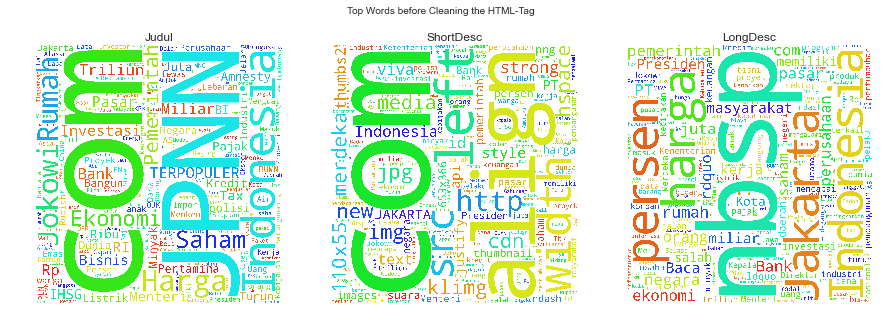

In [21]:
word3Cloud(DATA_JUDUL,
           DATA_SHORT,
           DATA_LONG,
           'Top Words before Cleaning the HTML-Tag')

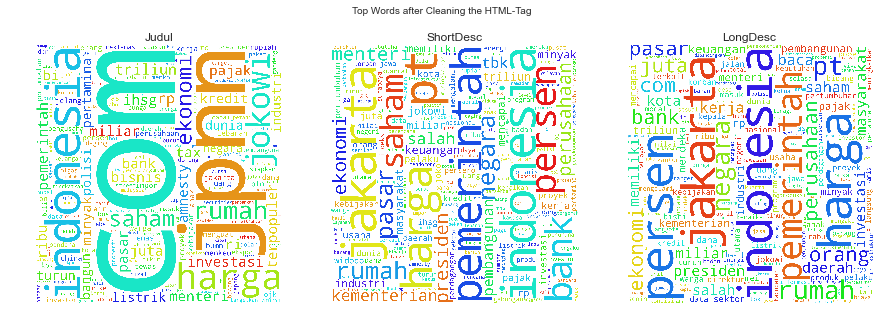

In [22]:
word3Cloud(DATA_JUDULStriped,
           DATA_SHORTStriped,
           DATA_LONGStriped,
           'Top Words after Cleaning the HTML-Tag')

In [ ]:
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

fs = 10
almost_black = '#262626'
sns.set()


X1 = tfidfv.fit_transform(DATA_JUDUL).toarray()
X2 = tfidfv.fit_transform(DATA_SHORT).toarray()
X3 = tfidfv.fit_transform(DATA_LONG).toarray()
y = DATA_TARGET.as_matrix()

# Instanciate a PCA object for the sake of easy visualisation
pca1 = PCA(n_components=2)
pca2 = PCA(n_components=2)
pca3 = PCA(n_components=2)

# Fit and transform x to visualise inside a 2D feature space
x1_vis = pca1.fit_transform(X1)
x2_vis = pca2.fit_transform(X2)
x3_vis = pca3.fit_transform(X3)

fig, axes = plt.subplots(ncols=3,figsize=(15,5))
# Plot the original data
palette = sns.color_palette()
axes[0].scatter(x1_vis[y == -1, 0], x1_vis[y == -1, 1], label="Class #Negatif", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
axes[0].scatter(x1_vis[y == 1, 0], x1_vis[y == 1, 1], label="Class #Positif", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)
axes[0].set_title('Judul', fontsize=fs)

axes[1].scatter(x2_vis[y == -1, 0], x2_vis[y == -1, 1], label="Class #Negatif", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
axes[1].scatter(x2_vis[y == 1, 0], x2_vis[y == 1, 1], label="Class #Positif", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)
axes[1].set_title('Short Description', fontsize=fs)

axes[2].scatter(x3_vis[y== -1, 0], x3_vis[y == -1, 1], label="Class #Negatif", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[0], linewidth=0.15)
axes[2].scatter(x3_vis[y == 1, 0], x3_vis[y == 1, 1], label="Class #Positif", alpha=0.5, 
            edgecolor=almost_black, facecolor=palette[2], linewidth=0.15)
axes[2].set_title('Long Description', fontsize=fs)

fig.suptitle('Gambaran 2 Dimensi 3 jenis Teks Berita (HTML and Stopwords Free)')
fig.show()
fig.savefig('img/PCA2.png', dpi=300)

## Explained Variance

In [163]:
print pca1.explained_variance_ratio_.sum() * 100
print pca2.explained_variance_ratio_.sum() * 100
print pca3.explained_variance_ratio_.sum() * 100

2.18384672943
2.15059792916
3.57709215929


In [198]:
print 'Jumlah Rata-rata kata teks Judul dan Keberagaman kata   : ',count_word.Judul.mean(),' ',X1.shape[1]
print 'Jumlah Rata-rata kata teks Short dan Keberagaman kata   : ',count_word.Short.mean(),' ',X2.shape[1]
print 'Jumlah Rata-rata kata teks Lengkap dan Keberagaman kata : ',count_word.Long.mean(),' ',X3.shape[1]

Jumlah Rata-rata kata teks Judul dan Keberagaman kata  :  7.57407407407   1512
Jumlah Rata-rata kata teks Short dan Keberagaman kata  :  14.8065843621   1831
Jumlah Rata-rata kata teks Lengkap dan Keberagaman kata :  254.201646091   11472


In [21]:
pickle.dump( DATA_JUDUL, open( "v1.4\DATA_JUDUL-v2.p", "wb" ) )
pickle.dump( DATA_SHORT, open( "v1.4\DATA_SHORT-v2.p", "wb" ) )
pickle.dump( DATA_LONG, open( "v1.4\DATA_LONG-v2.p", "wb" ) )
pickle.dump( DATA_TARGET, open( "v1.4\DATA_TARGET-v2.p", "wb" ) )

pickle.dump(DATA_JUDULStriped,open( "v1.4\DATA_JUDULStriped-v2.p", "wb" ))
pickle.dump(DATA_SHORTStriped,open( "v1.4\DATA_SHORTStriped-v2.p", "wb" ))
pickle.dump(DATA_LONGStriped,open( "v1.4\DATA_LONGStriped-v2.p", "wb" ))